In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.path.join(os.getcwd(), ".."), ".."))
sys.path.append(parent_dir)

In [22]:
from data_generation.simulations.grid import Grid, fractional_transformation, logistic_transformation, tangent_transformation
from data_generation.visualization.create_plots import plot_2D_vector_field, create_2D_vectorfield, plot_2D_vector_field_over_grid
from data_generation.models.tech_substitution import TechnologySubstitution
from data_generation.models.tech_substitution import TechSubNumericalSolver
from data_generation.models.general_ode_solver import FitzHughNagumoModel
from data_generation.models.general_ode_solver import GeneralODENumericalSolver
from data_generation.simulations.simulator import Simulator
from datasets.data_reconstruction import reconstruct_xyc

In [23]:
def plot_trajectories_in_transformed_space(results, grid, solver, control, dim1=0, dim2=1, 
                                           resolution=51, ax=None, max_trajectories=None, 
                                           save_to=None, title="Trajectories in Transformed Space"):
    """
    Plot trajectories in transformed space on top of a vector field.
    
    Args:
        results (DataFrame): Simulation results containing trajectories
        grid (Grid): The grid object containing transformation information
        solver (object): The solver object for the model
        control: Control parameter
        dim1, dim2: Dimensions to plot (default: 0, 1)
        resolution: Resolution of the vector field (default: 51)
        ax: Matplotlib axis (if None, a new figure is created)
        max_trajectories: Maximum number of trajectories to plot (None for all)
        save_to: Path to save the figure (default: None)
        title: Plot title (default: "Trajectories in Transformed Space")
    
    Returns:
        Matplotlib axis with the plot
    """
    # Create the vector field plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot the vector field
    plot_2D_vector_field_over_grid(grid, solver, control, dim1, dim2, 
                                   resolution, ax=ax, display_grid=True,
                                   title=title, broken_streamlines=False)
    
    # Group by trajectory_id
    trajectory_groups = list(results.groupby('trajectory_id'))
    
    # Limit the number of trajectories if specified
    if max_trajectories is not None and max_trajectories < len(trajectory_groups):
        import random
        trajectory_groups = random.sample(trajectory_groups, max_trajectories)
    
    # Plot each trajectory
    for traj_id, traj_data in trajectory_groups:
        # Sort by time
        traj_data = traj_data.sort_values('t0')
        
        # Initialize trajectory points array
        traj_points = np.zeros((len(traj_data) + 1, 2))
        
        # Fill in the points
        for i, (_, row) in enumerate(traj_data.iterrows()):
            if i == 0:
                # For the first row, use the x values as the starting point
                traj_points[i] = [row[f'x{dim1}'], row[f'x{dim2}']]
            
            # For all rows, add the y values as the next point
            traj_points[i+1] = [row[f'y{dim1}'], row[f'y{dim2}']]
        
        # Transform to z-space
        if grid.transformed_bool:
            z_points = np.zeros_like(traj_points)
            z_points[:, 0] = np.vectorize(grid.transformations[dim1])(traj_points[:, 0])
            z_points[:, 1] = np.vectorize(grid.transformations[dim2])(traj_points[:, 1])
        else:
            z_points = traj_points
        
        # Plot the trajectory
        ax.plot(z_points[:, 0], z_points[:, 1], 'o-', linewidth=1, markersize=3, alpha=0.7)
    
    if save_to is not None:
        plt.savefig(save_to)
    
    return ax

In [24]:
grid = Grid([(-np.inf, np.inf), (-np.inf, np.inf)], [8, 8],[logistic_transformation({'k': 1.0, 'x_0':0}), logistic_transformation({'k': 1.0, 'x_0':0})])
model = FitzHughNagumoModel(control_params=['b','I'])
solver = GeneralODENumericalSolver(model)
sim= Simulator(grid, model, solver)
control =np.array([2.0, 0.0])

In [25]:
X = np.atleast_2d(np.array([[1,-2], [3,-4], [6,5]]))
fshaped_control = np.array([[control]] * 10)
fal = solver.step(X, fshaped_control, delta_t = 5, num_steps=10, steady_control=False)
tru = solver.step(X, fshaped_control, delta_t = 5, num_steps=10, steady_control=True)

In [26]:
# Define delta_t values to test
delta_t = 1
# Create simulator
sim2 = Simulator(grid, model, solver)
# Run simulation with 5 timesteps
results2 = sim2.simulate(control, delta_t=delta_t, num_samples_per_cell=10, num_steps=20, save_result=False)

Simulation complete:
- 640 samples × 20 timesteps = 12800 total rows
- State dimensions: 2
- Control dimensions: 2


In [27]:
df = reconstruct_xyc(results2)
df['x_cell'] = df['x'].apply(grid.get_cell_index)
df['y_cell'] = df['y'].apply(grid.get_cell_index)


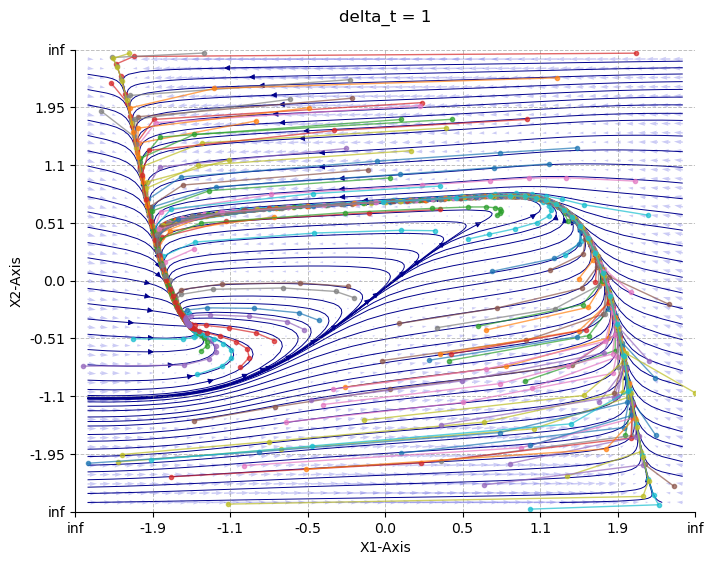

In [29]:
# Create a figure with subplots for each delta_t
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
plt.subplots_adjust(wspace=0.3)


# Plot trajectories (limiting to 15 random trajectories to avoid clutter)
plot_trajectories_in_transformed_space(
    results2, grid, solver, control, 
    ax=axes, max_trajectories=100,
    title=f'delta_t = {delta_t}'
)

# Save the figure
#plt.savefig('delta_t_comparison4.png', dpi=300, bbox_inches='tight')
plt.show()

Simulation complete:
- 640 samples × 100 timesteps = 64000 total rows
- State dimensions: 2
- Control dimensions: 2
Simulation complete:
- 640 samples × 100 timesteps = 64000 total rows
- State dimensions: 2
- Control dimensions: 2


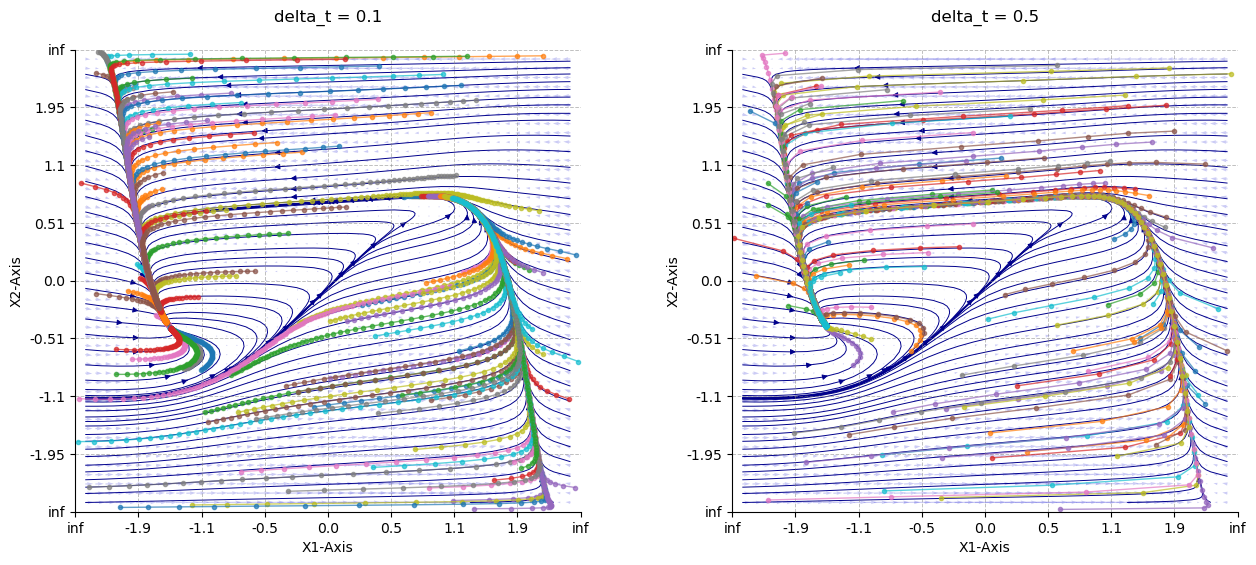

In [30]:
# Define delta_t values to test
delta_t_values = [0.1, 0.5]

# Create a figure with subplots for each delta_t
fig, axes = plt.subplots(1, len(delta_t_values), figsize=(15, 6))
plt.subplots_adjust(wspace=0.3)

# Test each delta_t
for i, delta_t in enumerate(delta_t_values):
    # Create simulator
    sim2 = Simulator(grid, model, solver)
    
    # Run simulation with 5 timesteps
    results2 = sim2.simulate(control, delta_t=delta_t, num_samples_per_cell=10, num_steps=100, save_result=False)
    
    # Plot trajectories (limiting to 15 random trajectories to avoid clutter)
    plot_trajectories_in_transformed_space(
        results2, grid, solver, control, 
        ax=axes[i], max_trajectories=100,
        title=f'delta_t = {delta_t}'
    )

# Save the figure
#plt.savefig('delta_t_comparison4.png', dpi=300, bbox_inches='tight')
plt.show()

## Tech Substitution

Simulation complete:
- 256 samples × 5 timesteps = 1280 total rows
- State dimensions: 2
- Control dimensions: 1
Simulation complete:
- 256 samples × 5 timesteps = 1280 total rows
- State dimensions: 2
- Control dimensions: 1


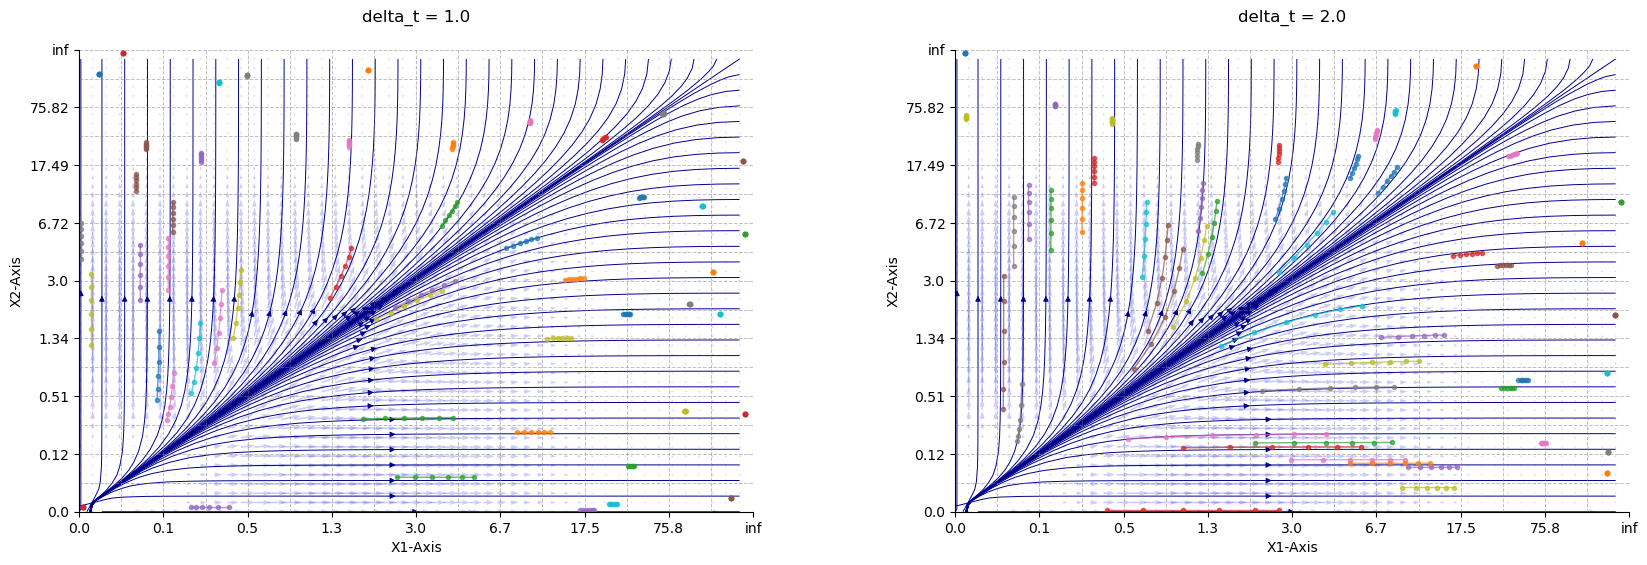

In [35]:
# Set up the model and grid
tbounds = [(0, np.inf), (0, np.inf)]
ttransformations = [tangent_transformation(3, alpha=0.5), tangent_transformation(3, alpha=0.5)]
tresolution = [16, 16]
tgrid = Grid(tbounds, tresolution, ttransformations)

# Create model and solver
tmodel = TechnologySubstitution()
tnum_solver = TechSubNumericalSolver(tmodel)
tcontrol = 1.01

# Define delta_t values to test
tdelta_t_values = [1.0, 2.0]

# Create a figure with subplots for each delta_t
fig, axes = plt.subplots(1, len(delta_t_values), figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# Test each delta_t
for i, delta_t in enumerate(tdelta_t_values):
    # Create simulator
    tsim = Simulator(tgrid, tmodel, tnum_solver)
    
    # Run simulation with 5 timesteps
    tresults = tsim.simulate(tcontrol, delta_t=delta_t, num_samples_per_cell=1, num_steps=5, save_result=False)
    
    # Plot trajectories (limiting to 15 random trajectories to avoid clutter)
    plot_trajectories_in_transformed_space(
        tresults, tgrid, tnum_solver, tcontrol, 
        ax=axes[i], max_trajectories=50,
        title=f'delta_t = {delta_t}'
    )

# Save the figure
plt.savefig('delta_t_comparison4.png', dpi=300, bbox_inches='tight')
plt.show()